<a href="https://colab.research.google.com/github/dimitarpg13/rag_architectures_and_concepts/blob/main/src/examples/graphRAG_toolkit/graphrag_demo/graphrag_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🕸️ GraphRAG Toolkit Demo

This notebook demonstrates how to use Microsoft's **GraphRAG** (Graph-based Retrieval-Augmented Generation) toolkit. GraphRAG enhances traditional RAG by building a knowledge graph from your documents, enabling more nuanced and comprehensive answers to complex queries.

## What is GraphRAG?

GraphRAG is an advanced RAG approach that:
- **Extracts entities and relationships** from documents to build a knowledge graph
- **Creates community summaries** for hierarchical understanding
- **Supports two query modes**:
  - **Local Search**: Best for specific questions about particular entities
  - **Global Search**: Best for broad questions requiring synthesis across the corpus

---


## 📦 1. Installation

First, let's install the GraphRAG toolkit and its dependencies.


In [1]:
# Install GraphRAG toolkit
!pip install "graphrag==2.7.0" --quiet
!pip install "numpy==1.26.4"
!pip install pandas scikit-learn

# Additional dependencies
!pip install python-dotenv pyyaml --quiet


## 🔧 2. Environment Setup

GraphRAG requires an LLM (Language Model) and an embedding model. We'll configure these using environment variables.

**Supported LLM providers:**
- OpenAI
- Azure OpenAI
- Other OpenAI-compatible APIs


In [2]:
import os
from pathlib import Path
from dotenv import load_dotenv

# Load environment variables from .env file if it exists
load_dotenv()

# Set your OpenAI API key (uncomment and set your key)
os.environ["GRAPHRAG_API_KEY"] = "<your_OPENAI_API_KEY_here>"

# Alternatively, you can set it directly:
os.environ["OPENAI_API_KEY"] = "<your_OPENAI_API_KEY_here>"

# Verify the API key is set
api_key = os.environ.get("GRAPHRAG_API_KEY") or os.environ.get("OPENAI_API_KEY")
if api_key:
    print("✅ API key is configured")
else:
    print("⚠️  Warning: No API key found. Please set GRAPHRAG_API_KEY or OPENAI_API_KEY")


✅ API key is configured


## 📁 3. Project Structure Setup

GraphRAG expects a specific project structure. Let's create it.


In [3]:
# Define project directories
PROJECT_DIR = Path.cwd()
INPUT_DIR = PROJECT_DIR / "input"
OUTPUT_DIR = PROJECT_DIR / "output"

# Create directories
INPUT_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"📂 Project directory: {PROJECT_DIR}")
print(f"📂 Input directory: {INPUT_DIR}")
print(f"📂 Output directory: {OUTPUT_DIR}")


📂 Project directory: /content
📂 Input directory: /content/input
📂 Output directory: /content/output


## 📄 4. Sample Data Preparation

For this demo, we'll create a sample text document. You can replace this with your own documents.


In [4]:
# Sample text about a fictional tech company for demonstration
sample_text = """
# TechCorp Innovation Report 2025

## Company Overview

TechCorp is a leading technology company founded in 2015 by Sarah Chen and Michael Rodriguez in San Francisco.
The company specializes in artificial intelligence solutions for enterprise customers. With over 5,000 employees
across 20 offices worldwide, TechCorp has become a major player in the AI industry.

## Leadership Team

Sarah Chen serves as the CEO and has led the company through multiple successful funding rounds. She previously
worked at Google and Stanford AI Lab. Michael Rodriguez, the CTO, oversees all technical operations and R&D.
He holds a PhD in Machine Learning from MIT.

The CFO, Jennifer Park, joined in 2019 from Goldman Sachs. She has been instrumental in the company's financial
growth and successful IPO in 2023. David Thompson leads the Sales division and has expanded the customer base
to include Fortune 500 companies like Amazon, Microsoft, and Walmart.

## Products and Services

TechCorp's flagship product, "AIAssist Pro", is an enterprise AI assistant that helps companies automate
customer service operations. It uses advanced natural language processing and has been deployed by over
200 enterprise customers.

"DataSense Analytics" is the company's second major product, offering predictive analytics for supply chain
optimization. Major clients include Walmart and Target, who have reported 30% efficiency improvements.

The newest product, "SecureAI", launched in 2024, focuses on AI-powered cybersecurity. It has already
attracted partnerships with three major banks: JPMorgan Chase, Bank of America, and Wells Fargo.

## Research and Development

TechCorp's R&D division, led by Dr. Emily Watson, has published over 50 papers in top AI conferences.
The team recently made a breakthrough in efficient transformer architectures, reducing compute costs by 40%.

The company collaborates with Stanford University, MIT, and Carnegie Mellon on various research projects.
Dr. Watson's team includes researchers from DeepMind, OpenAI, and Google Brain.

## Financial Performance

In 2024, TechCorp reported revenue of $2.5 billion, a 45% increase from the previous year. The company's
market cap reached $50 billion after the successful IPO. Major investors include Sequoia Capital,
Andreessen Horowitz, and SoftBank Vision Fund.

## Future Plans

TechCorp plans to expand into the healthcare AI market in 2025, with partnerships already in place with
Mayo Clinic and Cleveland Clinic. The company is also developing autonomous systems for logistics,
working with FedEx and UPS on pilot programs.

Sarah Chen announced plans to open new R&D centers in London, Singapore, and Tel Aviv to attract
global talent and serve international customers better.
"""

# Save the sample text to the input directory
input_file = INPUT_DIR / "techcorp_report.txt"
input_file.write_text(sample_text)

print(f"✅ Sample document saved to: {input_file}")
print(f"📝 Document length: {len(sample_text)} characters")


✅ Sample document saved to: /content/input/techcorp_report.txt
📝 Document length: 2745 characters


## ⚙️ 5. Configuration

GraphRAG uses a `settings.yaml` file for configuration. Let's create one with sensible defaults.


In [5]:
import yaml

# GraphRAG configuration
settings = {
    "models": {
        "default_chat_model": {
            "api_key": "${GRAPHRAG_API_KEY}",  # Uses environment variable
            "type": "openai_chat",
            "model": "gpt-4o-mini",  # Cost-effective model for demo
            "model_supports_json": True,
            "max_tokens": 4000,
            "temperature": 0,
        },

        "default_embedding_model": {
            "api_key": "${GRAPHRAG_API_KEY}",
            "type": "openai_embedding",
            "model": "text-embedding-3-small",
        }
    },
    "input": {
        "type": "file",
        "file_type": "text",
        "base_dir": "input",
        "file_encoding": "utf-8",
        "file_pattern": ".*\\.txt"
    },
    "storage": {
        "type": "file",
        "base_dir": "output"
    },
    "cache": {
        "type": "file",
        "base_dir": "cache"
    },
    "reporting": {
        "type": "file",
        "base_dir": "logs"
    },
    "chunks": {
        "size": 1200,
        "overlap": 100
    },
    "entity_extraction": {
        "max_gleanings": 1
    },
    "claim_extraction": {
        "enabled": True
    },
    "community_reports": {
        "max_length": 2000
    },
    "cluster_graph": {
        "max_cluster_size": 10
    }
}

# Save settings to YAML file
settings_file = PROJECT_DIR / "settings.yaml"
with open(settings_file, 'w') as f:
    yaml.dump(settings, f, default_flow_style=False, sort_keys=False)

print(f"✅ Configuration saved to: {settings_file}")
print("\n📋 Settings preview:")
print(yaml.dump(settings, default_flow_style=False, sort_keys=False))


✅ Configuration saved to: /content/settings.yaml

📋 Settings preview:
models:
  default_chat_model:
    api_key: ${GRAPHRAG_API_KEY}
    type: openai_chat
    model: gpt-4o-mini
    model_supports_json: true
    max_tokens: 4000
    temperature: 0
  default_embedding_model:
    api_key: ${GRAPHRAG_API_KEY}
    type: openai_embedding
    model: text-embedding-3-small
input:
  type: file
  file_type: text
  base_dir: input
  file_encoding: utf-8
  file_pattern: .*\.txt
storage:
  type: file
  base_dir: output
cache:
  type: file
  base_dir: cache
reporting:
  type: file
  base_dir: logs
chunks:
  size: 1200
  overlap: 100
entity_extraction:
  max_gleanings: 1
claim_extraction:
  enabled: true
community_reports:
  max_length: 2000
cluster_graph:
  max_cluster_size: 10



## 🔍 6. Initialize GraphRAG

Alternatively, you can use the CLI to initialize a project with `graphrag init --root .`

Let's verify the GraphRAG library is installed correctly.


In [6]:
# Check if we can import graphrag
try:
    import graphrag
    print(f"✅ GraphRAG version: {graphrag.__version__ if hasattr(graphrag, '__version__') else 'installed'}")
except ImportError as e:
    print(f"❌ GraphRAG not installed: {e}")
    print("Run: pip install graphrag")


✅ GraphRAG version: installed


## 🏗️ 7. Indexing Documents

The indexing process:
1. **Chunks** documents into smaller pieces
2. **Extracts** entities and relationships using the LLM
3. **Builds** a knowledge graph
4. **Creates** community summaries using the Leiden algorithm
5. **Generates** embeddings for semantic search

⚠️ **Note**: Indexing uses LLM API calls and may take several minutes and incur costs.


In [7]:
# Method 1: Using CLI (recommended for larger documents)
# Run this in a terminal: graphrag index --root .

# Method 2: Using Python API
import subprocess
import sys

def run_graphrag_index():
    """Run GraphRAG indexing process."""
    print("🚀 Starting GraphRAG indexing...")
    print("This may take several minutes depending on document size.\n")

    try:
        result = subprocess.run(
            [sys.executable, "-m", "graphrag", "index", "--root", str(PROJECT_DIR)],
            capture_output=True,
            text=True,
            cwd=str(PROJECT_DIR)
        )

        if result.returncode == 0:
            print("✅ Indexing completed successfully!")
            print(result.stdout)
        else:
            print("❌ Indexing failed:")
            print(result.stderr)

    except Exception as e:
        print(f"❌ Error running indexing: {e}")

# Uncomment the line below to run indexing
run_graphrag_index()


🚀 Starting GraphRAG indexing...
This may take several minutes depending on document size.

✅ Indexing completed successfully!
Starting pipeline with workflows: load_input_documents, create_base_text_units, create_final_documents, extract_graph, finalize_graph, extract_covariates, create_communities, create_final_text_units, create_community_reports, generate_text_embeddings
Starting workflow: load_input_documents

Workflow complete: load_input_documents
Starting workflow: create_base_text_units
  1 / 1 ............................................................................................
Workflow complete: create_base_text_units
Starting workflow: create_final_documents

Workflow complete: create_final_documents
Starting workflow: extract_graph
  1 / 1 ............................................................................................
  1 / 1 ............................................................................................
  1 / 49 
  2 / 49 
  3 / 49 
  4 / 4

### Alternative: Run indexing via command line

You can also run the indexing from the command line:


In [ ]:
# Uncomment to run indexing via shell
# !graphrag index --root .


## 🔎 8. Querying the Knowledge Graph

GraphRAG supports two types of queries:

### Local Search
- Best for **specific questions** about particular entities or facts
- Uses entity embeddings and local graph context
- Example: "Who is the CEO of TechCorp?"

### Global Search  
- Best for **broad questions** requiring synthesis across the entire corpus
- Uses community summaries for high-level understanding
- Example: "What are the main business areas of TechCorp?"


In [8]:
def run_graphrag_query(query: str, method: str = "local"):
    """
    Run a GraphRAG query.

    Args:
        query: The question to ask
        method: 'local' or 'global' search method
    """
    print(f"🔍 Query: {query}")
    print(f"📊 Method: {method.upper()} search\n")

    try:
        result = subprocess.run(
            [
                sys.executable, "-m", "graphrag", "query",
                "--root", str(PROJECT_DIR),
                "--method", method,
                "--query", query
            ],
            capture_output=True,
            text=True,
            cwd=str(PROJECT_DIR)
        )

        if result.returncode == 0:
            print("📝 Response:")
            print("-" * 50)
            print(result.stdout)
        else:
            print("❌ Query failed:")
            print(result.stderr)

    except Exception as e:
        print(f"❌ Error running query: {e}")


### Example Queries

Try these example queries after indexing is complete:


In [9]:
# Local Search - specific entity questions
# Uncomment after indexing is complete

run_graphrag_query("Who is Sarah Chen and what is her role at TechCorp?", method="local")


🔍 Query: Who is Sarah Chen and what is her role at TechCorp?
📊 Method: LOCAL search

📝 Response:
--------------------------------------------------
## Sarah Chen: Leadership at TechCorp

Sarah Chen is the CEO of TechCorp, a leading technology company specializing in artificial intelligence solutions for enterprise customers. She co-founded TechCorp in 2015 alongside Michael Rodriguez and has played a pivotal role in steering the company through various phases of growth and development. Her extensive background includes previous positions at Google and the Stanford AI Lab, which have significantly contributed to her credibility and expertise in the tech industry [Data: Entities (1); Relationships (0)].

### Contributions and Achievements

Under Sarah Chen's leadership, TechCorp has successfully navigated multiple funding rounds, culminating in a successful IPO in 2023. Her strategic vision and ability to attract investment have been instrumental in the company's financial growth, allowi

In [ ]:
run_graphrag_query("What products does TechCorp offer?", method="local")


🔍 Query: What products does TechCorp offer?
📊 Method: LOCAL search

📝 Response:
--------------------------------------------------
## TechCorp's Product Offerings

TechCorp, a leading technology company specializing in artificial intelligence solutions, has developed a diverse range of innovative products aimed at enhancing operational efficiency and addressing market needs. Here are the key products offered by TechCorp:

### 1. AIAssist Pro
AIAssist Pro is TechCorp's flagship product, designed as an enterprise AI assistant that automates customer service operations. This product utilizes advanced natural language processing capabilities and has been successfully deployed by over 200 enterprise customers, helping them streamline their customer interactions and improve service efficiency [Data: Reports (0); Entities (4)].

### 2. DataSense Analytics
DataSense Analytics is another major offering from TechCorp, providing predictive analytics specifically tailored for supply chain optimiza

In [10]:
# Global Search - broad synthesis questions
run_graphrag_query("What are the main themes and topics discussed in the document?", method="global")


🔍 Query: What are the main themes and topics discussed in the document?
📊 Method: GLOBAL search

📝 Response:
--------------------------------------------------
# Main Themes and Topics in the Document

The document provides a comprehensive overview of TechCorp, focusing on several key themes that highlight its position and strategy within the AI sector. Below are the main themes and topics discussed:

## Leadership and Management

The leadership team at TechCorp is a significant focus, with CEO Sarah Chen, CTO Michael Rodriguez, and CFO Jennifer Park being highlighted for their extensive experience in technology and finance. Their expertise is seen as a crucial factor contributing to the company's innovation and growth in the AI landscape [Data: Reports (0)].

## Product Offerings

TechCorp's diverse range of products is another central theme. The company offers solutions such as AIAssist Pro, DataSense Analytics, and SecureAI, which are designed to meet various enterprise needs. This 

In [11]:
run_graphrag_query("Summarize TechCorp's business strategy and future plans.", method="global")


🔍 Query: Summarize TechCorp's business strategy and future plans.
📊 Method: GLOBAL search

📝 Response:
--------------------------------------------------
# TechCorp's Business Strategy and Future Plans

TechCorp has established itself as a significant player in the AI sector through a well-defined business strategy that leverages its strong executive leadership, substantial financial backing, and a diverse product portfolio. The company's approach is multifaceted, focusing on innovation, strategic partnerships, and a robust client base.

## Executive Leadership

At the helm of TechCorp is a strong executive team, including CEO Sarah Chen, CTO Michael Rodriguez, and CFO Jennifer Park. Their combined expertise in technology and finance is pivotal in driving the company's innovation and growth initiatives. This leadership structure positions TechCorp to influence trends and advancements in AI solutions, ensuring that the company remains competitive in a rapidly evolving market [Data: Repo

## 📊 9. Exploring the Knowledge Graph

After indexing, GraphRAG creates several output files that you can explore:


In [12]:

import pandas as pd

def explore_graphrag_outputs():
    """Explore the GraphRAG output files."""
    #output_artifacts = OUTPUT_DIR / "artifacts"
    output_artifacts = OUTPUT_DIR

    if not output_artifacts.exists():
        print("⚠️  Output directory not found. Run indexing first.")
        return

    # List available output files
    print("📁 Available output files:")
    for file in output_artifacts.glob("*.parquet"):
        print(f"  - {file.name}")

    # Try to load and display entities
    entities_file = output_artifacts / "entities.parquet"
    if entities_file.exists():
        print("\n🏷️  Extracted Entities:")
        entities_df = pd.read_parquet(entities_file)
        # Add this check before using the column
        name_col = 'title' if 'title' in entities_df.columns else 'name'
        print(entities_df[[name_col, 'type', 'description']].head(10))

    # Try to load and display relationships
    rels_file = output_artifacts / "relationships.parquet"
    if rels_file.exists():
        print("\n🔗 Extracted Relationships:")
        rels_df = pd.read_parquet(rels_file)
        print(rels_df[['source', 'target', 'description']].head(10))

# Uncomment after indexing
explore_graphrag_outputs()


📁 Available output files:
  - community_reports.parquet
  - text_units.parquet
  - communities.parquet
  - documents.parquet
  - entities.parquet
  - relationships.parquet

🏷️  Extracted Entities:
                  title          type  \
0              TECHCORP  ORGANIZATION   
1            SARAH CHEN        PERSON   
2     MICHAEL RODRIGUEZ        PERSON   
3         JENNIFER PARK        PERSON   
4        DAVID THOMPSON        PERSON   
5          AIASSIST PRO         EVENT   
6  DATA SENSE ANALYTICS         EVENT   
7              SECUREAI         EVENT   
8   STANFORD UNIVERSITY  ORGANIZATION   
9                   MIT  ORGANIZATION   

                                         description  
0  TechCorp is a leading technology company found...  
1  Sarah Chen is the CEO of TechCorp, who has led...  
2  Michael Rodriguez is the CTO of TechCorp, over...  
3  Jennifer Park is the CFO of TechCorp, who join...  
4  David Thompson leads the Sales division at Tec...  
5  AIAssist Pro is Te

## 🎨 10. Visualizing the Knowledge Graph

Let's create a visualization of the extracted knowledge graph.


In [13]:
# Install visualization libraries
!pip install networkx matplotlib --quiet


/tmp/ipython-input-769764664.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10')
/tmp/ipython-input-769764664.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


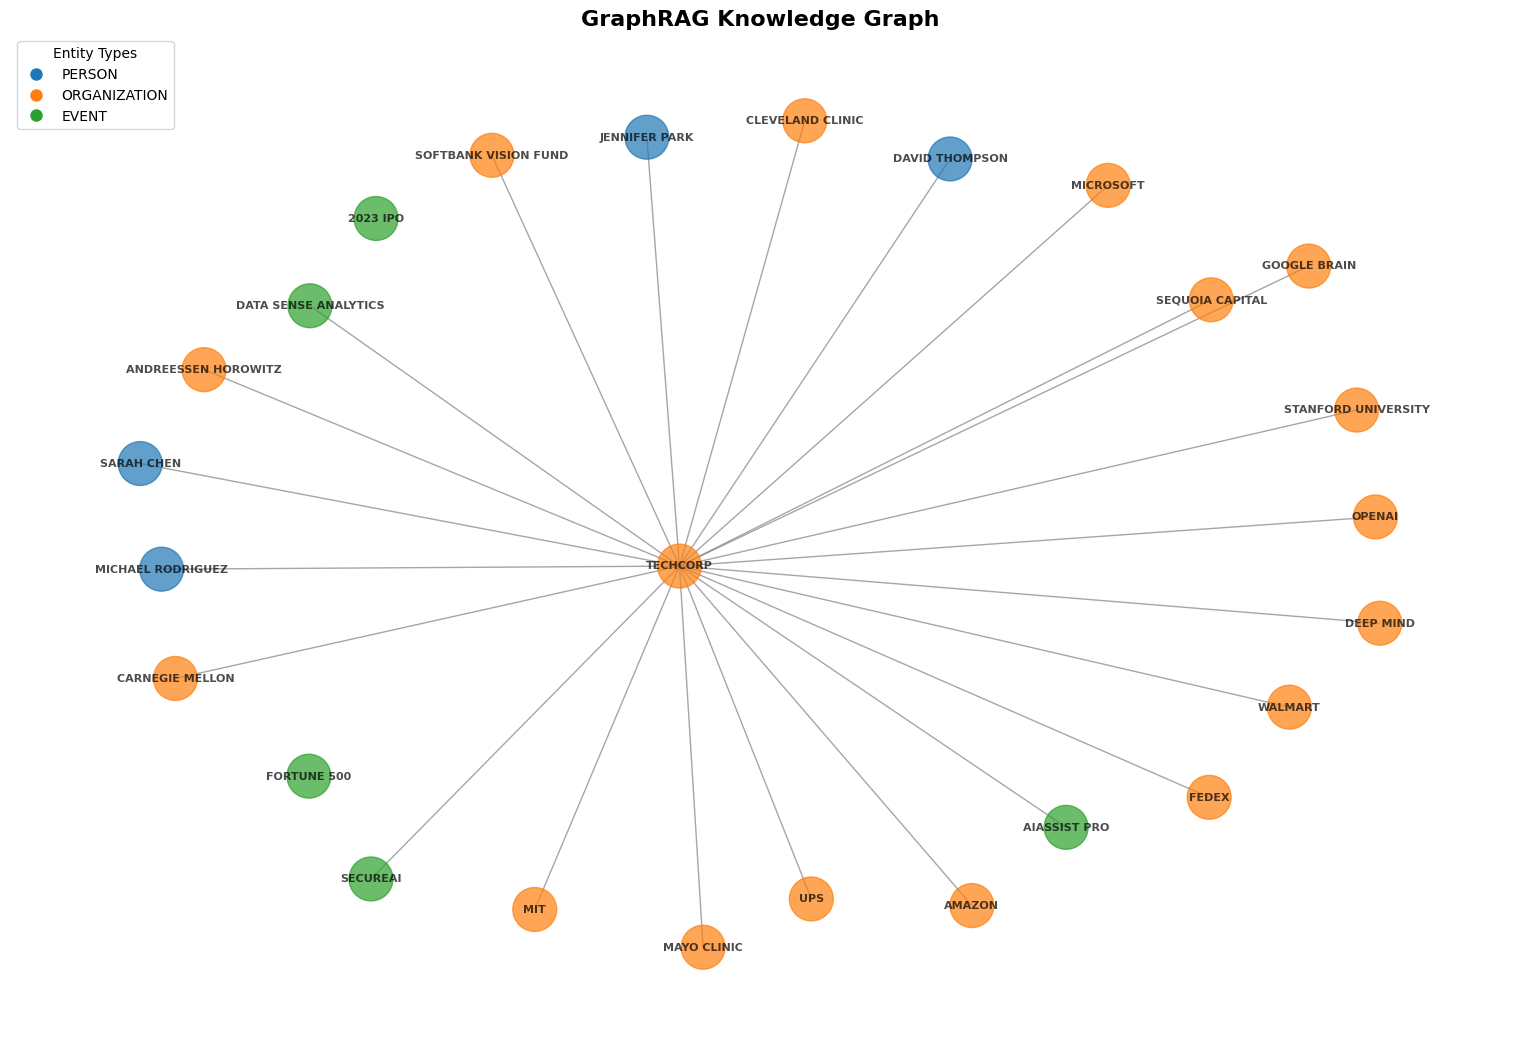


📊 Graph Statistics:
   Nodes: 26
   Edges: 23
   Entity Types: ['PERSON', 'ORGANIZATION', 'EVENT']


In [14]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_knowledge_graph():
    """Create a visualization of the knowledge graph."""
    #output_artifacts = OUTPUT_DIR / "artifacts"
    output_artifacts = OUTPUT_DIR

    entities_file = output_artifacts / "entities.parquet"
    rels_file = output_artifacts / "relationships.parquet"

    if not entities_file.exists() or not rels_file.exists():
        print("⚠️  Output files not found. Run indexing first.")
        return

    # Load data
    entities_df = pd.read_parquet(entities_file)
    rels_df = pd.read_parquet(rels_file)

    # Create graph
    G = nx.Graph()

    name_col = 'title' if 'title' in entities_df.columns else 'name'
    # Add nodes
    for _, row in entities_df.iterrows():
        G.add_node(row[name_col], type=row.get('type', 'UNKNOWN'))

    # Add edges
    for _, row in rels_df.iterrows():
        G.add_edge(row['source'], row['target'])

    # Create visualization
    plt.figure(figsize=(15, 10))

    # Color nodes by type
    node_types = nx.get_node_attributes(G, 'type')
    unique_types = list(set(node_types.values()))
    color_map = plt.cm.get_cmap('tab10')
    colors = [color_map(unique_types.index(node_types.get(node, 'UNKNOWN')) % 10) for node in G.nodes()]

    # Layout
    pos = nx.spring_layout(G, k=2, iterations=50)

    # Draw
    nx.draw(G, pos,
            node_color=colors,
            node_size=1000,
            font_size=8,
            font_weight='bold',
            with_labels=True,
            edge_color='gray',
            alpha=0.7)

    plt.title("GraphRAG Knowledge Graph", fontsize=16, fontweight='bold')

    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                   markerfacecolor=color_map(i % 10),
                                   markersize=10, label=t)
                       for i, t in enumerate(unique_types)]
    plt.legend(handles=legend_elements, loc='upper left', title='Entity Types')

    plt.tight_layout()
    plt.savefig(PROJECT_DIR / 'knowledge_graph.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n📊 Graph Statistics:")
    print(f"   Nodes: {G.number_of_nodes()}")
    print(f"   Edges: {G.number_of_edges()}")
    print(f"   Entity Types: {unique_types}")

# Uncomment after indexing
visualize_knowledge_graph()


## 11. Cleanup

Optional: Remove generated files to start fresh.


In [ ]:
import shutil

def cleanup():
    """Remove all generated files."""
    dirs_to_remove = ['output', 'cache', 'logs']

    for dir_name in dirs_to_remove:
        dir_path = PROJECT_DIR / dir_name
        if dir_path.exists():
            shutil.rmtree(dir_path)
            print(f"Removed: {dir_path}")

    print("Cleanup complete!")

# Uncomment to run cleanup
# cleanup()


---

## Summary

In this notebook, we covered:

1. **Installation** of GraphRAG toolkit
2. **Configuration** of LLM and embedding models
3. **Project setup** with proper directory structure
4. **Document indexing** to build the knowledge graph
5. **Querying** using local and global search methods
6. **Exploration** of extracted entities and relationships
7. **Visualization** of the knowledge graph

## Resources

- [GraphRAG Documentation](https://microsoft.github.io/graphrag/)
- [GraphRAG GitHub Repository](https://github.com/microsoft/graphrag)
- [GraphRAG Research Paper](https://arxiv.org/abs/2404.16130)

## Tips

- Use **Local Search** for specific entity lookups
- Use **Global Search** for summarization and thematic questions
- Adjust `chunk_size` based on your document structure
- Consider using `gpt-4o` for better extraction quality
- Monitor API costs during indexing of large document sets
